In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from torch_geometric.loader import DataLoader
from dataset_copy import *
from model import *
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score, roc_auc_score
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = 'cpu'

Dataset type:  <class 'dataset_copy.ChiralLigands'>
Dataset node features:  7
Dataset length:  <bound method ChiralLigands.len of ChiralLigands(686)>
Dataset sample:  Data(x=[92, 7], edge_index=[2, 196], edge_attr=[196, 2], y=[1], category=[1], ligand='C1=C(Cc2ccccc2)[C@H]2C=C(Cc3ccccc3)[C@@H]1C2', substrate='O=C1C=CCC1', boron='c1ccc(B2OB(c3ccccc3)OB(c3ccccc3)O2)cc1', ligand_num=1, ligand_id='L3.1', ligand_fam='fam1', idx=0)
Sample features:  tensor([[6., 3., 3., 0., 1., 0., 1.],
        [6., 3., 3., 0., 1., 0., 1.],
        [6., 4., 4., 0., 0., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 4., 4., 0., 1., 1., 1.],
        [6., 3., 3., 0., 1., 0., 1.],
        [6., 3., 3., 0., 1., 0., 1.],
        [6., 4., 4., 0., 0., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3.,

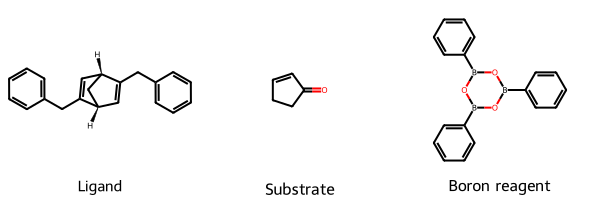

In [4]:
ligands = ChiralLigands(root = '../Data', filename = 'data_aug.csv')

print("Dataset type: ", type(ligands))
print("Dataset node features: ", ligands.num_features)
print("Dataset length: ", ligands.len)
print("Dataset sample: ", ligands[0])
print('Sample features: ',  ligands[0].x)
print('Sample outcome: ',  ligands[0].y)
print('Sample cat: ',  ligands[0].category)

ms = [ligands[0].ligand, ligands[0].substrate, ligands[0].boron]
ms = [Chem.MolFromSmiles(mol) for mol in ms]
Chem.Draw.MolsToGridImage(ms,molsPerRow=3,subImgSize=(200,200),legends=['Ligand', 'Substrate', 'Boron reagent']) 

In [5]:
model = GCN_loop(ligands.num_features, embedding_size = 64, gnn_layers=2, improved=False)
model.to(device)

GCN_loop(
  (initial_conv): GCNConv(7, 64)
  (conv_layers): ModuleList(
    (0): GCNConv(64, 64)
  )
  (readout1): Linear(in_features=128, out_features=64, bias=True)
  (readout2): Linear(in_features=64, out_features=1, bias=True)
)

In [6]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

In [7]:
categories = np.array([ligands[i].category.detach().numpy() for i in range(len(ligands))])
x = [ligands[i].x.detach().numpy() for i in range(len(ligands))]
groups = [ligands[i].ligand_num for i in range(len(ligands))]

In [8]:
folds = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=23)
train_idx = []
test_idx = []

for i, (train, test) in enumerate(folds.split(x, categories, groups)):
    train_idx.append(train)
    test_idx.append(test)

In [9]:
fold = 9
train_loader = DataLoader(ligands[train_idx[fold]], batch_size=40, shuffle=True)
test_loader = DataLoader(ligands[test_idx[fold]], batch_size=40, shuffle=False)

In [10]:
def calculate_metrics(y_pred, y_true, epoch, type):
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_pred)
    
    if epoch % 100 == 0:
        print('\n \n' + type)
        print(f"\n Confusion matrix: \n {confusion_matrix(y_pred, y_true)}")
        print(f"F1 Score: {f1_score(y_true, y_pred):.2f}")
        print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
        print(f"Precision: {prec:.2f}")
        print(f"Recall: {rec:.2f}")
        print(f"ROC AUC: {roc:.2f}")

    return prec, rec, roc 

In [11]:
def train(epoch):

    all_preds = []
    all_y = []
    total_loss = 0
    step = 0

    # Enumerate over the data
    for batch in train_loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred = model(batch.x.float(), 
                  batch.edge_index,
                  batch.batch) 
      
      # Calculating the loss and gradients
      loss = loss_fn(pred, torch.unsqueeze(batch.category.float(), dim = 1))
      loss.backward()  
      # Update using the gradients
      optimizer.step()   

      total_loss += loss.item()
      step += 1

      all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
      all_y.append(batch.category.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate (all_y).ravel() 
    metrics = calculate_metrics(all_preds, all_labels, epoch, 'train')

    return torch.tensor(total_loss/step), all_preds, all_labels, metrics

In [12]:
def test(epoch):

    all_preds = []
    all_y = []
    total_loss = 0
    step = 0

    # Enumerate over the data
    for batch in test_loader:
      # Use GPU
      batch.to(device)  
      # Passing the node features and the connection info
      pred = model(batch.x.float(), 
                  batch.edge_index,
                  batch.batch) 
      
      # Calculating the loss and gradients
      loss = loss_fn(pred, torch.unsqueeze(batch.category.float(), dim = 1))
  
      total_loss += loss.item()
      step += 1

      all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
      all_y.append(batch.category.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate (all_y).ravel() 
    metrics = calculate_metrics(all_preds, all_labels, epoch, 'test')

    return torch.tensor(total_loss/step), all_preds, all_labels, metrics

In [13]:
epochs = 231

loss_train = []
loss_test = []

pred_train = []
pred_test = []

labels_train = []
labels_test = []

prec_train = []
prec_test = []

rec_train = []
rec_test = []

roc_train = []
roc_test = []

best_loss = 10_000
early_stopping_counter =0

In [14]:
model_directory = '/Users/ed/Documents/PhD_Documents/Experiments/ChiralLigands/Data_augm_exp/GNN/saved_models/'
model_filename = f'GCN_f_{fold}_l_{model.gnn_layers}_em_{model.embedding_size}_e_{epochs}.pth'
model_filepath = os.path.join(model_directory, model_filename)

In [15]:
if os.path.exists(model_filepath):
    # Load the existing model
    model = torch.load(model_filepath)

else:
    for epoch in range (epochs):
                
        if early_stopping_counter <= 1000:
            # Training
            model.train()
            loss, pred, label, metrics = train(epoch=epoch)
            loss = loss.detach().cpu().numpy()

            if epoch % 5 == 0:
                loss_train.append(loss) 
                prec_train.append(metrics[0])
                rec_train.append(metrics[1])
                roc_train.append(metrics[2])

            if epoch % 100 == 0:
                print(f"Epoch {epoch} | Train Loss {loss}")
                pred_train.append(pred)
                labels_train.append(label)

                    # Testing
                
            if epoch % 5 == 0:
                model.eval()
                loss, pred, label, metrics = test(epoch=epoch)
                loss = loss.detach().cpu().numpy()

                if float(loss) < best_loss:
                    best_loss = loss
                    early_stopping_counter = 0
                    best_pred = pred
                    best_y = label
                    best_prec = metrics[0]
                    best_rec = metrics[1]
                    best_roc = metrics[2]
                    best_epoch = epoch

                else:
                    early_stopping_counter += 1

                
                loss_test.append(loss)
                prec_test.append(metrics[0])
                rec_test.append(metrics[1])
                roc_test.append(metrics[2])

                if epoch % 10 == 0:
                    print(f"Epoch {epoch} | Test Loss {loss}")
                    pred_test.append(pred)
                    labels_test.append(label)
        
            last_epoch = epoch
                    
        else:
            print("Early stopping due to no improvement.")
            print(f'Best loss was {best_loss}')
            last_epoch = epoch
            #break

    print(f'Finishing training with best test loss: {best_loss}')
    print(f'Best test precision: {best_prec}')
    print(f'Best test recall: {best_rec}')
    print(f'Best test auroc: {best_roc}')
    print(f'Best epoch: {best_epoch}')
    torch.save(model, model_filepath)

In [16]:
from torch_geometric.explain import Explainer, GNNExplainer, CaptumExplainer
from plot_importances import *

In [17]:
feat_labels = ['Atomic number', 'Atom degree', 'Atom hybridization', 'Aromaticity', 'Atom in ring', 'Atom chirality', 'Molecule configuration']

In [18]:
explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('ShapleyValueSampling'),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='raw',
    ),
)

In [19]:
explain = DataLoader(ligands[test_idx[fold]], batch_size=1)

In [20]:
mol = get_graph_by_idx(explain, 438)

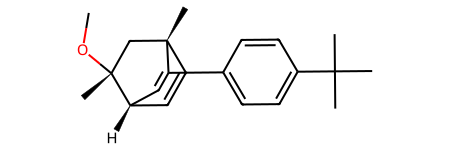

In [21]:
Chem.MolFromSmiles(mol.ligand[0])

In [22]:
explanation = explainer(x = mol.x, edge_index=mol.edge_index,  batch_index=mol.batch)

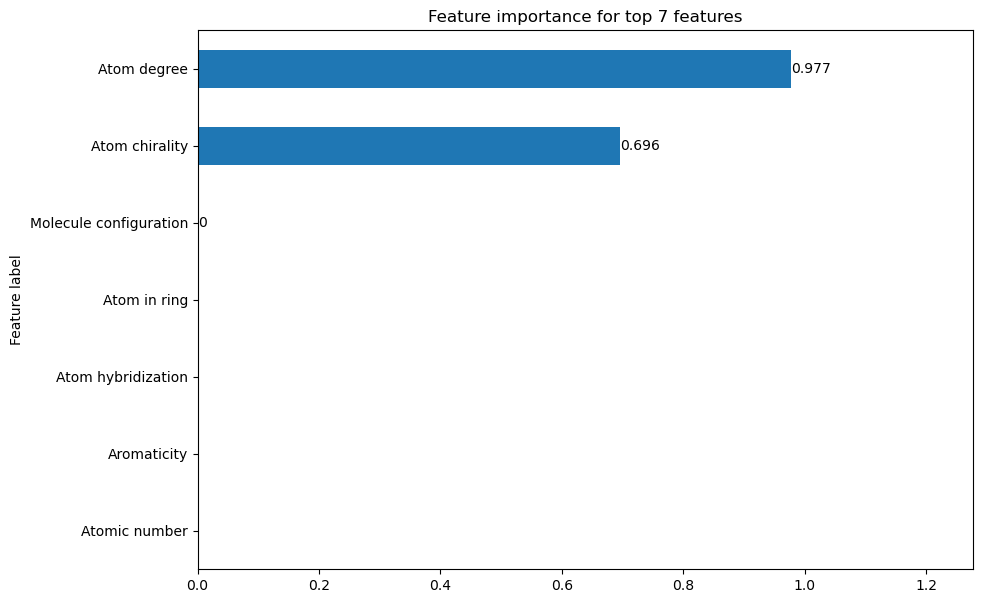

In [23]:
explanation.visualize_feature_importance(path=None, top_k=7, feat_labels = feat_labels)

In [25]:
main(mol_graph=mol, mol='l', explanation=explanation, palette='normal')